# Exploring Spotify Listening History

## A Quarantine Project

#### In the summer of 2017, I created a last.fm account (https://www.last.fm/user/gps56) in order to record my listening habits on Spotify.  Last.fm allows you to link music streaming services, and serves to record your listens (referred to as 'scrobbles').  You can download your data to csv, or use last.fm's API to pull it directly.  

#### I love music and I love coding (particularly data science), so over the past few weeks I used my free time in quarantine to take a peek into my listening habits.  I had 3 years of listening history and over 50,000+ song listens to wade through.  Take a look!

First, importing packages I used.

I primarily used `pandas` for interacting with the data.  `pandas` has a weird quirk where it warns you whenever you create a new column as a reference to a previous one.  This can get messy if you're going to be mangling columns, but if you're mostly just creating new columns and leaving previous ones untouched, you can turn off the warning.

In [1]:
import os, sys
import pandas as pd, numpy as np
import datetime, time

pd.options.mode.chained_assignment = None

I downloaded my scrobbling history to a csv.  Read into a `pandas` `DataFrame` as usual.  The flat file contains artist/album/song along with the date/time of each listen.

In [3]:
__scrobbles__ = 'downloads/gps56-2.csv'

df = pd.read_csv(__scrobbles__, header = None, names = ['artist', 'album', 'song', 'datetime'])

#### Some preliminary preprocessing

Remove any records that have blank date/time info (there should be none).
The date/time column is given in UTC.  Since I've spent the past 3 years living in NYC, I'll subtract 5 hours from this.

In [5]:
df = df[~df.datetime.isna()]
df.datetime.isna().value_counts()

False    55281
Name: datetime, dtype: int64

In [6]:
df.datetime = pd.to_datetime(df.datetime) - pd.Timedelta(hours = 5)

Here's what the 10 most recent listens are (at the time of downloading the data).

In [8]:
df.head(10)

,artist,album,song,datetime
1,Drake,Dark Lane Demo Tapes,Pain 1993 (with Playboi Carti),2020-05-04 19:34:00
2,Juice WRLD,Death Race For Love,Empty,2020-05-04 17:07:00
3,Juice WRLD,Death Race For Love,Rider,2020-05-04 17:05:00
4,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 17:05:00
5,Juice WRLD,Death Race For Love,She’s The One,2020-05-04 16:58:00
6,Juice WRLD,Death Race For Love,10 Feet,2020-05-04 16:56:00
7,Juice WRLD,Death Race For Love,Ring Ring (with Rvssian feat. Clever),2020-05-04 16:53:00
8,Juice WRLD,Death Race For Love,Maze,2020-05-04 16:50:00
9,Juice WRLD,Death Race For Love,Empty,2020-05-04 16:46:00
10,Juice WRLD,Death Race For Love,Make Believe,2020-05-04 16:44:00


# Time Analysis

### Checking out my listening habits throughout the days, weeks, and years.  Made some plots too.

Using `matplotlib` is a given, and `seaborn` gives us a nice wrapper with cleaner syntax and some nice themes.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", color_codes = True)

# these lists with proper order will come in handy later ... 
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Let's get some basic metrics out of the way.

The total number of listens is just the length of the dataframe.

In [16]:
total_listens = len(df)
print(total_listens, 'total listens')

55281 total listens


The number of days I listened to music is the length of the deduplicated date column.

In [18]:
unique_days = len(df.datetime.dt.date.drop_duplicates())
print(unique_days, 'days with a listen recorded')

973 days with a listen recorded


Those are only days that I listened to music -- there were definitely days where I didnt listen to anything.
To get total days elapsed, I take the difference between the `max` and `min` of the date column.

In [26]:
all_days = (df.datetime.dt.date.max() - df.datetime.dt.date.min()).days
passive_days = all_days - unique_days
print("{} days elapsed; {} days without a listen".format(all_days, passive_days))

1040 days elapsed; 67 days without a listen


Similarly, we can get the number of 'active' weeks by grouping the dataframe by year and week, then taking length of the resulting `groupby` object.  This is an easy way to get the number of unique combinations of two separate derived series in situ. 


In [29]:
unique_weeks = len(df.groupby([df.datetime.dt.year, df.datetime.dt.week]))
print(unique_weeks, 'active weeks')

148 active weeks


First, lets take a look at how my total listens are divided by day.

In [47]:
mean_listens_per_day_active = total_listens/unique_days
mean_listens_per_day_total = total_listens/all_days
print("{} listens on an active day; {} listens per day overall".format(*map(lambda x: round(x, 1), [mean_listens_per_day_active, mean_listens_per_day_total])))

56.8 listens on an active day; 53.2 listens per day overall


Looking at average listens per week.

In [50]:
mean_listens_per_week = total_listens/unique_weeks
print("{} listens in an average week".format(round(mean_listens_per_week, 1)))

373.5 listens in an average week


Now we can dive into seeing how my listens are distributed in an average week.

In [10]:
day_counts = df.datetime.dt.day_name().value_counts().reindex(day_order)
day_counts

Monday       7189
Tuesday      9388
Wednesday    7812
Thursday     9536
Friday       9580
Saturday     7017
Sunday       4759
Name: datetime, dtype: int64

This is nice, but a more useful metric might be the fraction of each rather than total count.
here's a simple function that takes a `pd.Series` of integers as its input and returns the series back with float percentages.

In [15]:
def get_percents(value_counts):
    # convert value counts series to percentages
    value_counts /= value_counts.sum()
    value_counts = value_counts.round(3)*100
    return value_counts

In [51]:
day_counts_percent = get_percents(day_counts)
day_counts_percent

Monday       13.0
Tuesday      17.0
Wednesday    14.1
Thursday     17.3
Friday       17.3
Saturday     12.7
Sunday        8.6
Name: datetime, dtype: float64

Similarly, we can get the percent of total listens per week and month.

In [57]:
week_counts_percent = get_percents(df.datetime.dt.week.value_counts().sort_index())
week_counts_percent_2019 = get_percents(df[df.datetime.dt.year == 2019].datetime.dt.week.value_counts().sort_index())
# week_counts_percent

In [53]:
month_counts_percent = get_percents(df.datetime.dt.month_name().value_counts().reindex(month_order))
month_counts_percent_2019 = get_percents(df[df.datetime.dt.year == 2019].datetime.dt.month_name().value_counts().reindex(month_order))
month_counts_percent

January       9.2
February      8.4
March        10.5
April         7.2
May           4.1
June          5.6
July          7.4
August       10.8
September     9.2
October       9.7
November      9.3
December      8.5
Name: datetime, dtype: float64

This is just the amount of listens on each day.

In [298]:
individual_day_counts = df.datetime.dt.date.value_counts().sort_index()
individual_day_counts_percent = get_percents(df.datetime.dt.date.value_counts())
individual_day_counts

2017-06-29     2
2017-07-01     1
2017-07-04    11
2017-07-05    34
2017-07-06    65
              ..
2020-04-30    79
2020-05-01    74
2020-05-02    22
2020-05-03    36
2020-05-04    57
Name: datetime, Length: 969, dtype: int64

In [425]:
# 

In [493]:
to_plot = {'Original': individual_day_counts,
        '10-day': individual_day_counts.rolling(10).mean(),
        '30-day': individual_day_counts.rolling(30).mean(),
        '90-day': individual_day_counts.rolling(90).mean()}

multiline_plot_df = pd.concat(to_plot.values(), axis = 1)
multiline_plot_df.columns = to_plot.keys()
multiline_plot_df

,Original,10-day,30-day,90-day
2017-06-29,2,NaN,NaN,NaN
2017-07-01,1,NaN,NaN,NaN
2017-07-04,11,NaN,NaN,NaN
2017-07-05,34,NaN,NaN,NaN
2017-07-06,65,NaN,NaN,NaN
...,...,...,...,...
2020-04-30,79,94.0,59.933333,71.033333
2020-05-01,74,82.7,61.333333,71.133333
2020-05-02,22,60.8,59.766667,69.955556
2020-05-03,36,58.0,59.466667,68.966667


In [288]:
# function to set colors according to values in barplot
def colors_from_values(values, palette_name = "YlGnBu"):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

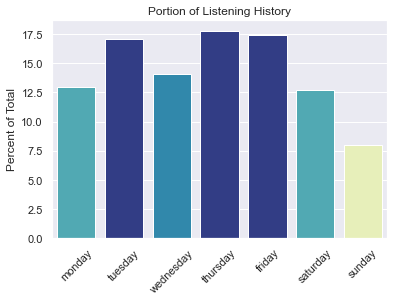

In [477]:
plt.figure()
sns.barplot(day_counts_percent.index, day_counts_percent.values, palette = colors_from_values(day_counts_percent.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45)
plt.show()

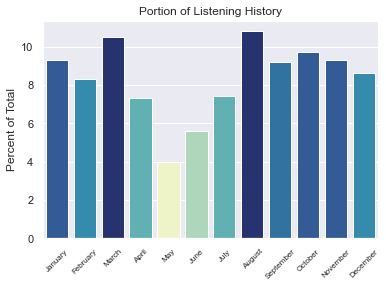

In [478]:
plt.figure()
sns.barplot(x = month_counts_percent_all.index, y = month_counts_percent_all.values, palette = colors_from_values(month_counts_percent_all.values))
plt.title('Portion of Listening History')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=45, fontsize = 8)
plt.show()

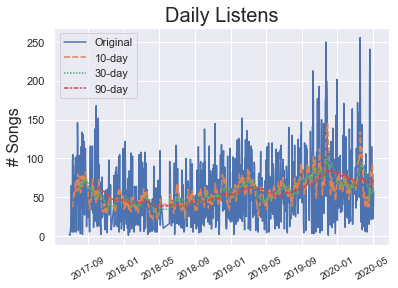

In [481]:
plt.figure()
sns.lineplot(data = multiline_plot_df)
plt.title('Daily Listens', fontsize = 20)
plt.ylabel('# Songs', fontsize=16)
plt.xticks(rotation=30, fontsize = 10)
plt.show()

## Most popular times

In [16]:
hour_map = {0: '12 AM',
 1: '1 AM',
 2: '2 AM',
 3: '3 AM',
 4: '4 AM',
 5: '5 AM',
 6: '6 AM',
 7: '7 AM',
 8: '8 AM',
 9: '9 AM',
 10: '10 AM',
 11: '11 AM',
 12: '12 PM',
 13: '1 PM',
 14: '2 PM',
 15: '3 PM',
 16: '4 PM',
 17: '5 PM',
 18: '6 PM',
 19: '7 PM',
 20: '8 PM',
 21: '9 PM',
 22: '10 PM',
 23: '11 PM'}

In [372]:
np.array(list(hour_map.keys()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [17]:
df['hour_str'] = pd.Categorical(df.datetime.dt.hour.map(hour_map), categories = hour_map.values())

In [68]:
hour_counts = df.hour_str.value_counts().sort_index()

In [162]:
average_hour_counts = hour_counts/len(df.datetime.dt.date.unique())
average_hour_counts

12 AM    0.733746
1 AM     0.662539
2 AM     0.593395
3 AM     0.650155
4 AM     0.610939
5 AM     0.779154
6 AM     2.719298
7 AM     2.908153
8 AM     2.423117
9 AM     2.572755
10 AM    3.167183
11 AM    4.062951
12 PM    4.408669
1 PM     4.021672
2 PM     3.925697
3 PM     4.960784
4 PM     4.560372
5 PM     3.407637
6 PM     2.559340
7 PM     2.256966
8 PM     1.793602
9 PM     1.367389
10 PM    1.123839
11 PM    0.780186
Name: hour_str, dtype: float64

In [159]:
hour_counts_percents = get_percents(average_hour_counts)

In [394]:
day_palette = colors_from_values(np.array(list(hour_map.keys())), palette_name = 'twilight_shifted')

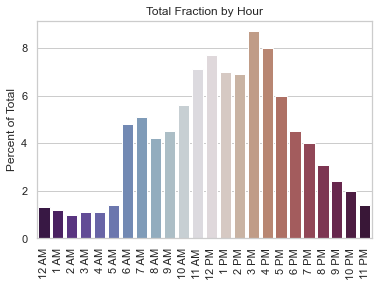

In [464]:
plt.figure()
sns.barplot(x = hour_counts_percents.index, y = hour_counts_percents.values, palette = day_palette)
plt.title('Total Fraction by Hour')
plt.ylabel('Percent of Total', fontsize=12)
plt.xticks(rotation=90)
plt.show()

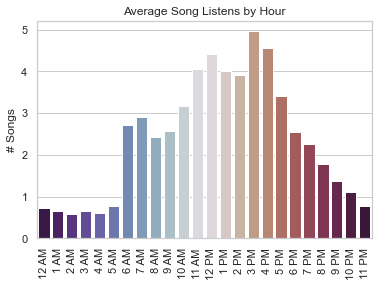

In [463]:
plt.figure()
sns.barplot(x = average_hour_counts.index, y = average_hour_counts.values, palette = day_palette)
plt.title('Average Song Listens by Hour')
plt.ylabel('# Songs', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Hour breakdown, split by days

In [100]:
grouped_days = df.groupby('day_name')

In [103]:
# hour_counts

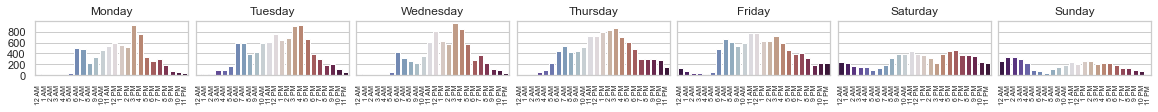

In [405]:
fig, axes = plt.subplots(nrows = 1, ncols = len(grouped_days), sharey = True, figsize=(20,1))
fig.subplots_adjust(wspace = 0.05)

plt.yticks(np.arange(0, max(hour_counts), 200))

for ax, (day, sub_df) in zip(axes, grouped_days):
    day_hour_counts = sub_df.hour_str.value_counts().sort_index()
    # day_hour_counts_percents = get_percents(day_hour_counts)
    ax.set_title(day.capitalize())
    ax.tick_params(axis = 'x', rotation = 90, labelsize = 7)
    # ax.tick_params(axis = 'y')

    sns.barplot(x = day_hour_counts.index, y = day_hour_counts.values, ax = ax, palette = day_palette)

plt.show()

# artist analysis

In [459]:
top_10_artists = df.artist.value_counts().head(10)
top_5_artists = df.artist.value_counts().head(5)
top_10_artists

Drake            3563
Playboi Carti    3128
Future           1736
Juice WRLD       1579
Young Thug       1509
Travis Scott     1198
Tory Lanez        917
Lil Uzi Vert      830
Smokepurpp        746
Mac Miller        692
Name: artist, dtype: int64

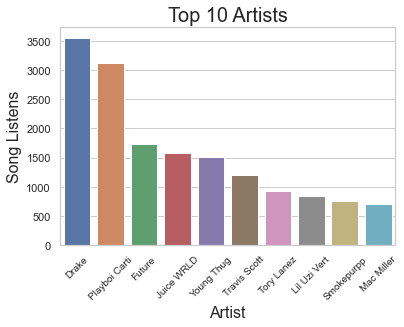

In [424]:
plt.figure()
sns.barplot(x = top_10_artists.index, y = top_10_artists.values, )
plt.title('Top 10 Artists', fontsize = 20)
plt.ylabel('Song Listens', fontsize=16)
plt.xlabel('Artist', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.show()

### lets check out how i listened to these artists over time

In [430]:
def get_artist_series(df, artist):
    return df[df.artist.str.contains(artist)].datetime.dt.date.value_counts().sort_index()

In [447]:
get_artist_series(df, 'Mac Miller').rolling(10).mean()

2017-07-17    NaN
2017-07-18    NaN
2017-07-20    NaN
2017-07-21    NaN
2017-07-26    NaN
             ... 
2020-04-13    3.2
2020-04-20    3.2
2020-04-24    3.2
2020-04-27    3.1
2020-04-28    2.7
Name: datetime, Length: 158, dtype: float64

In [494]:
to_plot_artists = {artist: get_artist_series(df, artist).rolling(60).mean() for artist in top_5_artists.index}

multiline_plot_df_artist = pd.concat(to_plot_artists.values(), axis = 1).sort_index()
multiline_plot_df_artist.columns = to_plot_artists.keys()
multiline_plot_df_artist

,Original,10-day,30-day,90-day
2017-06-29,2,NaN,NaN,NaN
2017-07-01,1,NaN,NaN,NaN
2017-07-04,11,NaN,NaN,NaN
2017-07-05,34,NaN,NaN,NaN
2017-07-06,65,NaN,NaN,NaN
...,...,...,...,...
2020-04-30,79,94.0,59.933333,71.033333
2020-05-01,74,82.7,61.333333,71.133333
2020-05-02,22,60.8,59.766667,69.955556
2020-05-03,36,58.0,59.466667,68.966667


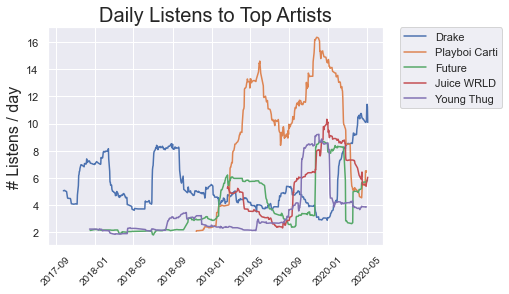

In [490]:
plt.figure()
sns.lineplot(data = multiline_plot_df_artist, dashes = False,)
plt.title('Daily Listens to Top Artists', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### lets check out my most listened-to songs

In [511]:
def get_song_series(df, song):
    return df[df.song == song].datetime.dt.date.value_counts().sort_index()

In [509]:
top_10_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(10)
top_5_songs = df.groupby([df.song, df.artist]).size().sort_values(ascending = False).head(5)
top_10_songs.values

array([521, 508, 301, 250, 249, 222, 218, 208, 201, 201])

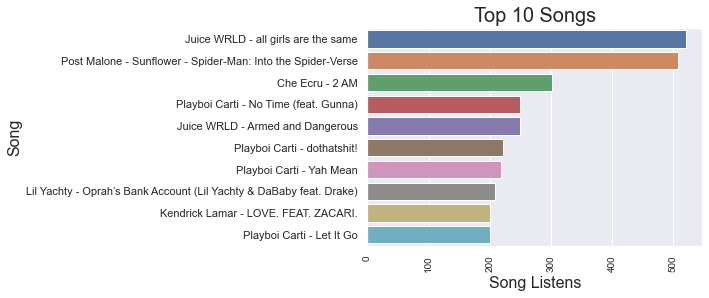

In [548]:
plt.figure()
song_titles = ['{} - {}'.format(artist, song) for song, artist in top_10_songs.index]
sns.barplot(y = song_titles, x = top_10_songs.values, orient = 'h')
plt.title('Top 10 Songs', fontsize = 20)
plt.xlabel('Song Listens', fontsize=16)
plt.ylabel('Song', fontsize=16)
plt.xticks(rotation=90, fontsize = 10)
plt.show()

In [538]:
to_plot_songs = {'{} - {}'.format(artist, song): get_song_series(df, song).rolling(7).mean() for song, artist in top_5_songs.index}

multiline_plot_df_songs = pd.concat(to_plot_songs.values(), axis = 1).sort_index()
multiline_plot_df_songs.columns = to_plot_songs.keys()
# multiline_plot_df_songs

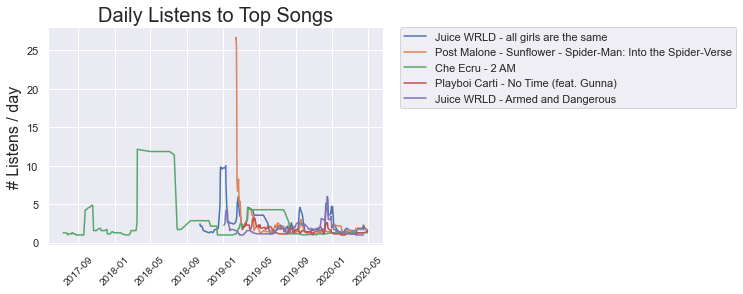

In [539]:
plt.figure()
sns.lineplot(data = multiline_plot_df_songs, dashes = False,)
plt.title('Daily Listens to Top Songs', fontsize = 20)
plt.ylabel('# Listens / day', fontsize=16)
plt.xticks(rotation=45, fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()